<a href="https://colab.research.google.com/github/amritasenthil/amritasenthil.github.io/blob/master/high_probability_low_certainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install plotnine
# ! pip install --upgrade scipy==1.2.0
import keras

In [2]:
import numpy as np
import pandas as pd
import plotnine as p9 
import matplotlib.pylab as plt

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier

# High on Probability, Low on Certainty 

> Warning: Contains Counter Intuition

Machine Learning models don't just classify, they also approximate probabilities. The issue is that they "approximate" and they should not directly be interpreted as an actual degree of certainty. The goal of this document is to demonstrate why this is the case as well as hint on how to solve this issue.

## Example Dataset 

To demonstrate this effect I will train a `KNeighborsClassifier` on a toy dataset that is generated by the scikit-learn api. The code for this is listed below as well as an image of the distribution of classes.

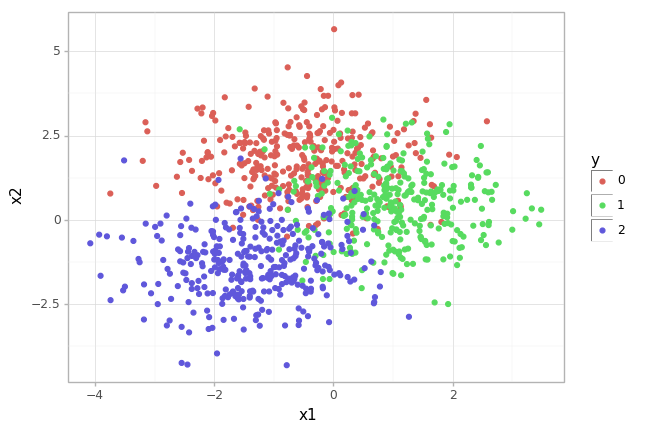

<ggplot: (8794073229148)>

In [ ]:
X, y = make_blobs(n_samples=1000, center_box=(-2, 2), random_state=42)
mod = KNeighborsClassifier(n_neighbors=20).fit(X, y)

df = pd.DataFrame({"x1": X[:, 0], 
                   "x2": X[:, 1], 
                   "y": y.astype(np.object), 
                   "pred": mod.predict(X).astype(str), 
                   "max_proba": mod.predict_proba(X).max(axis=1)})

(p9.ggplot() + 
  p9.geom_point(data=df, mapping=p9.aes("x1", "x2", color="y")) + 
  p9.theme_light())

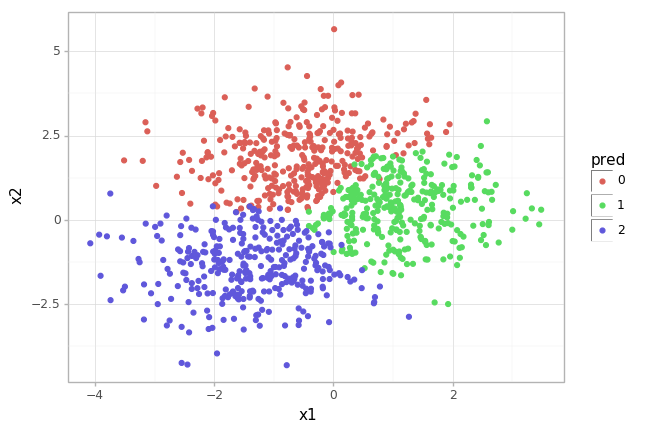

<ggplot: (-9223363242784849685)>

In [ ]:
(p9.ggplot() + 
  p9.geom_point(data=df,
                mapping=p9.aes("x1", "x2", color="pred")) + 
  p9.theme_light())

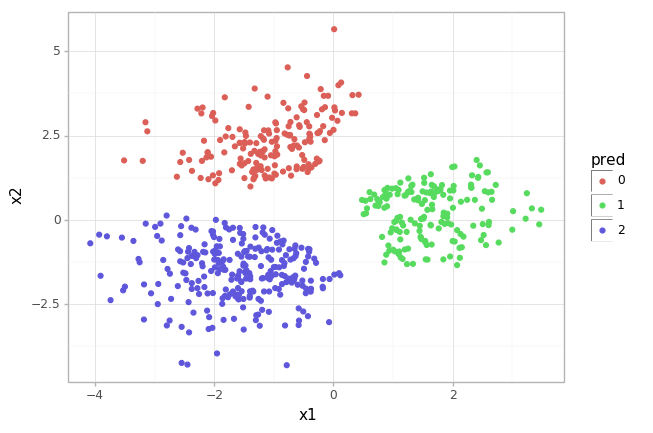

<ggplot: (8794073255919)>

In [ ]:
  (p9.ggplot() + 
  p9.geom_point(data=df.loc[lambda d: d['max_proba'] > 0.8], 
                mapping=p9.aes("x1", "x2", color="pred")) + 
  p9.theme_light())

This is a dataset that is relatively easy to train and fit.

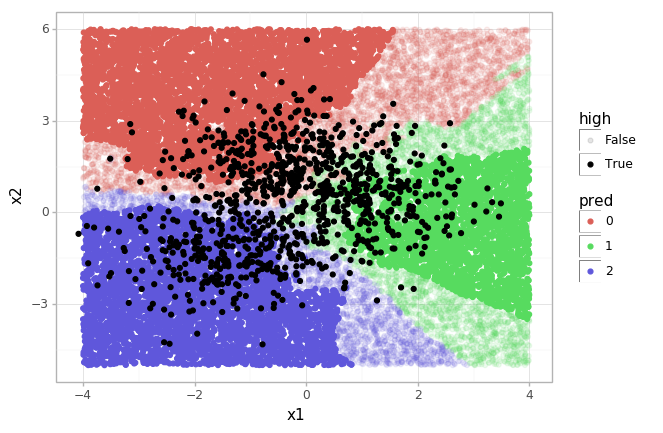

<ggplot: (8794069714019)>

In [ ]:
n = 20000
X, y = make_blobs(n_samples=1000, center_box=(-2, 2), random_state=42)
mod = KNeighborsClassifier(20, weights="distance").fit(X, y)

simdf = (pd.DataFrame({"x1": np.random.uniform(-4, 4, n), 
                       "x2": np.random.uniform(-5, 6, n)})
         .assign(pred = lambda d: mod.predict(d[['x1', 'x2']].values).astype(np.object))
         .assign(high = lambda d: mod.predict_proba(d[['x1', 'x2']].values).max(axis=1) > 0.9))

(p9.ggplot() + 
  p9.geom_point(data=simdf, mapping=p9.aes("x1", "x2", color="pred", alpha="high")) + 
  p9.geom_point(data=df, mapping=p9.aes("x1", "x2")) + 
  p9.theme_light())

Notice that there is a lot of areas where the algorithm gives a very high probability but where the algorithm has never seen any data. It is really strange that an algorithm suggests to give certainty to regions where it hasn't seen any data.

To emphesize, it gets crazier from you zoom out.

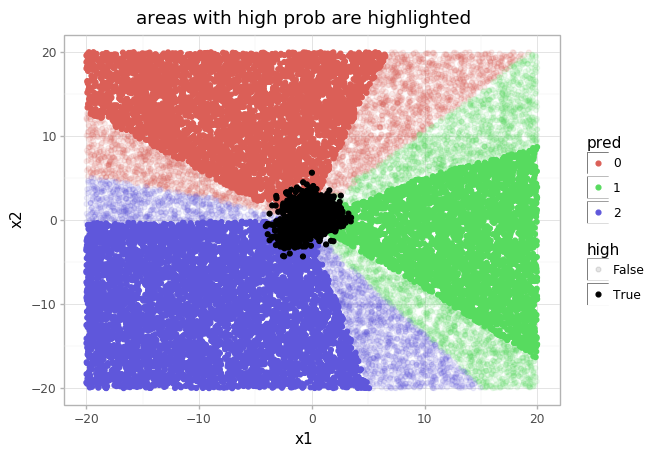

<ggplot: (-9223363262578670939)>

In [ ]:
n = 20000
X, y = make_blobs(n_samples=1000, center_box=(-2, 2), random_state=42)
mod = KNeighborsClassifier(20, weights="distance").fit(X, y)

simdf = (pd.DataFrame({"x1": np.random.uniform(-20, 20, n), 
                       "x2": np.random.uniform(-20, 20, n)})
         .assign(pred = lambda d: mod.predict(d[['x1', 'x2']].values).astype(np.object))
         .assign(high = lambda d: mod.predict_proba(d[['x1', 'x2']].values).max(axis=1) > 0.9))

(p9.ggplot() + 
  p9.geom_point(data=simdf, mapping=p9.aes("x1", "x2", color="pred", alpha="high")) + 
  p9.geom_point(data=df, mapping=p9.aes("x1", "x2")) + 
  p9.theme_light() + 
  p9.ggtitle("areas with high prob are highlighted"))

## General Issue 

One might consider that this issue is because of our choice in algorithm. But this issue is actually rather general. To demonstrate this, consider the following results from other algorithms.

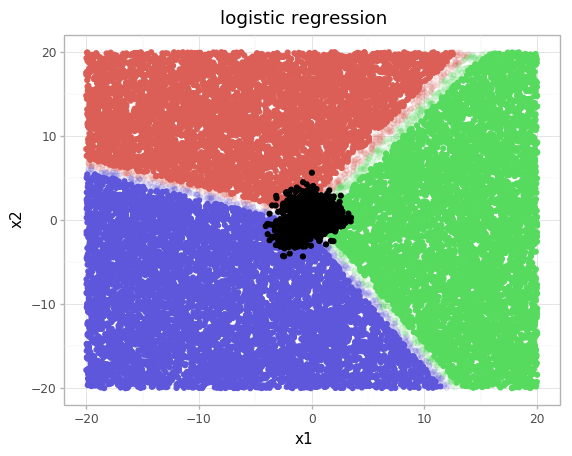

<ggplot: (-9223363262581517319)>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X, y = make_blobs(n_samples=1000, center_box=(-2, 2), random_state=42)
mod = LogisticRegression(solver='lbfgs', multi_class='auto').fit(X, y)

simdf = (pd.DataFrame({"x1": np.random.uniform(-20, 20, n), 
                       "x2": np.random.uniform(-20, 20, n)})
         .assign(pred = lambda d: mod.predict(d[['x1', 'x2']].values).astype(np.object))
         .assign(high = lambda d: mod.predict_proba(d[['x1', 'x2']].values).max(axis=1) > 0.9))

(p9.ggplot() + 
  p9.geom_point(data=simdf, mapping=p9.aes("x1", "x2", color="pred", alpha="high")) + 
  p9.geom_point(data=df, mapping=p9.aes("x1", "x2")) + 
  p9.theme_light() + 
  p9.ggtitle("logistic regression") + 
  p9.theme(legend_position="none"))

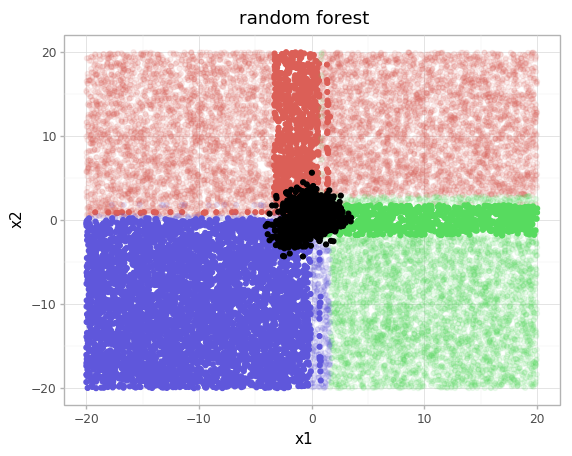

<ggplot: (8774271086789)>

In [ ]:
X, y = make_blobs(n_samples=1000, center_box=(-2, 2), random_state=42)
mod = RandomForestClassifier(n_estimators=100).fit(X, y)

simdf = (pd.DataFrame({"x1": np.random.uniform(-20, 20, n), 
                       "x2": np.random.uniform(-20, 20, n)})
         .assign(pred = lambda d: mod.predict(d[['x1', 'x2']].values).astype(np.object))
         .assign(high = lambda d: mod.predict_proba(d[['x1', 'x2']].values).max(axis=1) > 0.9))

(p9.ggplot() + 
  p9.geom_point(data=simdf, mapping=p9.aes("x1", "x2", color="pred", alpha="high")) + 
  p9.geom_point(data=df, mapping=p9.aes("x1", "x2")) + 
  p9.theme_light() + 
  p9.ggtitle("random forest") + 
  p9.theme(legend_position="none"))

## General Problem 

The output from `.predict_proba()` is an **approximation** of a probability. It might be a proxy for probability but this is different from being a direct link to certainty. This is because machine learning models are often designed for interpolation, not extrapolation. This means that applying them in an extrapolation usecase is tricky business. 

It would be less of an issue if machine learning models weren't designed to *always* give a result. There is usually no mechanism that assigns doubt to an outcome if a decision is made outside of a comfort zone. 

Lucky for us, this last part of the problem we can be fixed with a little bit of probability glue.

## The Density Trick

What if we used an outlier detection algorithm to detect if a point we're trying to predict is outside of our comfort zone? One way of getting there is to use a Gaussian Mixture Model on our original dataset $X$. We can measure what areas have likely values in $X$ and with that we can say what area's aren't.

In [ ]:
X, y = make_blobs(n_samples=1000, center_box=(-2, 2), random_state=42)
mod = KNeighborsClassifier(20, weights="distance").fit(X, y)

The intelligence of our approach is listed in these two lines of code.

In [ ]:
out = GaussianMixture(3).fit(X)
boundary = np.quantile(out.score_samples(X), 0.01)

When we get new values then this learned boundary, or threshold, can be used to detect the region where we might be comfortable with interpolation. The result of this is listed below.

In [ ]:
simdf = (pd.DataFrame({"x1": np.random.uniform(-6, 6, n), 
                       "x2": np.random.uniform(-6, 6, n)})
         .assign(pred = lambda d: mod.predict(d.values).astype(np.object))
         .assign(prob = lambda d: out.score_samples(d[['x1', 'x2']].values) > boundary))

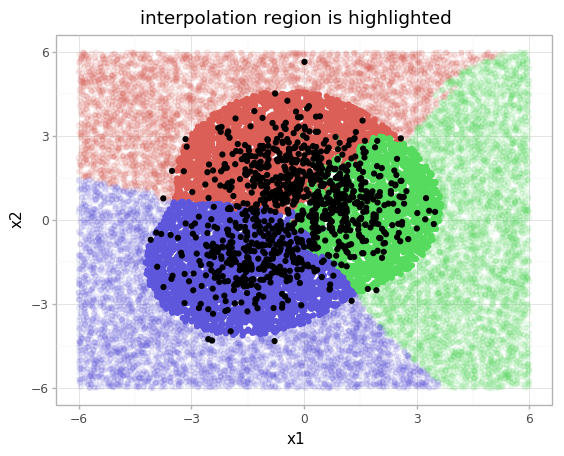

<ggplot: (8774276131669)>

In [ ]:
(p9.ggplot() + 
  p9.geom_point(data=simdf, mapping=p9.aes("x1", "x2", color="pred", alpha="prob")) + 
  p9.geom_point(data=df, mapping=p9.aes("x1", "x2")) + 
  p9.theme_light() + 
  p9.ggtitle("interpolation region is highlighted") + 
  p9.theme(legend_position="none"))

We could also try the one vs. all approach here.

# Conclusion 

Personally, I'm charmed by the idea of designing a predictive system that can say "Nope! Not predicting this one!". It sounds like a very sane way of dealing with uncertainty. Using an outlier algorithm as a cog in this system makes sense too. I personally like the idea of using a GMM for this because having a probability distribution as an output gives nice flexibility. 

I've implemented this algorithm in [scikit-lego](https://scikit-lego.readthedocs.io/en/latest/mixture-methods.html). Feel free to use it. 